In [1]:
import json
from collections import defaultdict, Counter
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import scipy.stats as stats
import gzip
import scipy.sparse as sparse
import statsmodels.api as sm
import random
from sklearn.metrics import precision_recall_curve, roc_curve
from itertools import combinations, product
import matplotlib
import csv

In [2]:
ped_file = '../../DATA/ssc.hg38/ssc.ped'
phase_dir = '../phased_ssc.hg38_del'
sim_file = '../sibpair_similarity/ssc.hg38_del_similarity.txt'

#ped_file = '../../DATA/ssc/ssc.ped'
#phase_dir = '../phased_ssc_del_qs'
#sim_file = '../sibpair_similarity/ssc_del_qs_similarity.txt'

colors=['#ef6c00', '#4db6ac', '#ce93d8ff']


In [3]:
sibpair_to_sim = dict()
with open(sim_file, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split('\t')
        sibpair_to_sim[(pieces[0], tuple(sorted([pieces[1], pieces[2]])))] = (float(pieces[3]), float(pieces[4]))

# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()
in_ped = set()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            if 'ssc' in ped_file:
                child_id = child_id.replace('.', '_')
                f_id = f_id.replace('.', '_')
                m_id = m_id.replace('.', '_')
            child_id_to_affected[child_id] = disease_status
            child_id_to_sex[child_id] = sex

            if f_id != '0' and m_id != '0':
                if (fam_id, m_id, f_id) not in fam_to_inds:
                    fam_to_inds[(fam_id, m_id, f_id)] = [m_id, f_id]
                fam_to_inds[(fam_id, m_id, f_id)].append(child_id)
            in_ped.add(m_id)
            in_ped.add(f_id)
            in_ped.add(child_id)

print('ped loaded')
print('children', len(child_id_to_affected))

with open('%s/deletions.json' % phase_dir) as f:
    deletions = json.load(f)

# filter deletions
deletions = [d for d in deletions if d['length']>=1000]
print('remaining deletions', len(deletions))

deletions = [d for d in deletions if d['is_inherited']]
print('remaining deletions', len(deletions))
    
deletions = [d for d in deletions if not d['is_hts']]
print('remaining deletions', len(deletions))


ped loaded
children 9371
remaining deletions 369025
remaining deletions 369025
remaining deletions 225818


In [58]:
print(len(fam_to_inds))

2459


In [80]:
def get_mad_outliers(x):
    median = np.median(x, axis=0)
    diff = np.abs(x - median)
    mad = np.median(diff)
    
    is_outlier = 0.6745 * diff/mad > 10
    
    #is_outlier = np.zeros((len(x),), dtype=bool)
    
    #plt.hist([x[~is_outlier], x[is_outlier]], stacked=True)
    #plt.show()
    
    return is_outlier

    
sibpairs = sorted(sibpair_to_sim.keys())
sibpairs = [(fam, x) for (fam, x) in sibpairs if child_id_to_affected[x[0]] in ['1', '2'] and \
                   child_id_to_affected[x[1]] in ['1', '2'] and (child_id_to_affected[x[0]]=='2' or child_id_to_affected[x[1]]=='2')]
    
print('sibpairs', len(sibpairs))
    
probands, siblings = [], []
child_to_proband_indices = defaultdict(list)
child_to_sibling_indices = defaultdict(list)
    
for i, (fam, (sib1, sib2)) in enumerate(sibpairs):
    if child_id_to_affected[sib1]=='2' and child_id_to_affected[sib2]=='2':
        sibs = [sib1, sib2]
        random.shuffle(sibs)
        proband, sibling = sibs
    elif child_id_to_affected[sib1]=='2':
        proband, sibling = sib1, sib2
    else:
        proband, sibling = sib2, sib1
        
    probands.append((fam, proband))
    siblings.append((fam, sibling))
    child_to_proband_indices[(fam, proband)].append(i)
    child_to_sibling_indices[(fam, sibling)].append(i)

    
assert (len(probands) == len(sibpairs)) and (len(siblings) == len(sibpairs))
    
sibpair_to_index = dict([(x, i) for i, x in enumerate(sibpairs)])
    
# sibpair, mat/pat
sim = np.array([sibpair_to_sim[x][:2] for x in sibpairs])
                      
# sibpair, mat/pat
deletions_match = np.zeros((len(sibpairs), 2), dtype=int)    
    
# child, mat/pat
children = sorted(set(probands) | set(siblings))
child_to_index = dict([(x, i) for i, x in enumerate(children)])
child_deletions = np.zeros((len(children), 2), dtype=int) 

for d in deletions:
    for sib1, sib2 in combinations(d['trans'], 2):
        key = (d['family'], tuple(sorted([sib1, sib2])))
        if key in sibpair_to_index:
            deletions_match[sibpair_to_index[key], int(d['is_pat'])] += (d['length'])
            
    for child in d['trans']:
        key = (d['family'], child)
        if key in child_to_index:
            child_deletions[child_to_index[key], int(d['is_pat'])] += (d['length'])
    
       
is_aut_aut = np.array([child_id_to_affected[sib1]=='2' and child_id_to_affected[sib2]=='2' for fam, (sib1, sib2) in sibpairs])

proband_is_f = np.array([child_id_to_sex[x]=='2' for fam, x in probands])
sibling_is_f = np.array([child_id_to_sex[x]=='2' for fam, x in siblings])


sibpairs 1925


3
1699108
2


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in log10


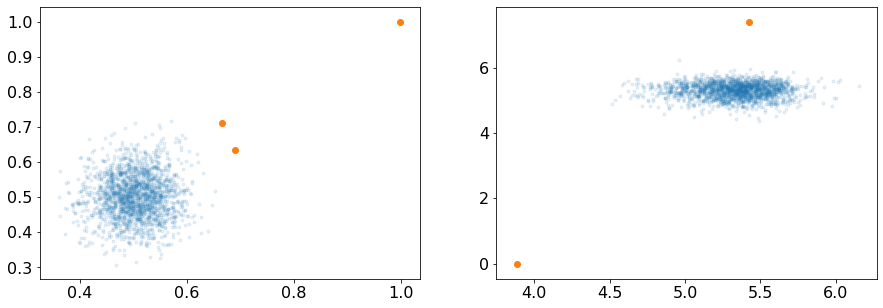

In [81]:
from scipy.stats import multivariate_normal   


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

# fit gaussian
covariance_matrix = np.cov(sim.T)

#calculating the mean
mean_values = np.mean(sim, axis=0)

#multivariate normal distribution
model = multivariate_normal(cov=covariance_matrix,mean=mean_values)

#finding the outliers
is_sim_outlier = model.pdf(sim).reshape(-1) < 0.01
print(np.sum(is_sim_outlier))

plt.scatter(sim[:, 0], sim[:, 1], alpha=0.1, marker='.')
plt.scatter(sim[is_sim_outlier, 0], sim[is_sim_outlier, 1])

print(np.max(deletions_match[~is_outlier, :]))

plt.subplot(1, 2, 2)

# fit gaussian
covariance_matrix = np.cov(np.clip(np.log10(deletions_match.T), 0, None))

#calculating the mean
mean_values = np.mean(np.clip(np.log10(deletions_match), 0, None), axis=0)

#multivariate normal distribution
model = multivariate_normal(cov=covariance_matrix,mean=mean_values)

#finding the outliers
is_del_outlier = model.pdf(np.clip(np.log10(deletions_match), 0, None)).reshape(-1) < 0.001
print(np.sum(is_del_outlier))

plt.scatter(np.clip(np.log10(deletions_match[:, 0]), 0, None),
                    np.clip(np.log10(deletions_match[:, 1]), 0, None), alpha=0.1, marker='.')
plt.scatter(np.clip(np.log10(deletions_match[is_del_outlier, 0]), 0, None), 
                    np.clip(np.log10(deletions_match[is_del_outlier, 1]), 0, None))

plt.show()

is_outlier = is_sim_outlier | is_del_outlier


In [83]:
print(np.sum(is_outlier))
print(deletions_match[is_del_outlier & ~is_sim_outlier])
print(np.where(is_del_outlier & ~is_sim_outlier)[0])
print([sibpairs[i] for i in np.where(is_del_outlier & ~is_sim_outlier)[0]])
print(deletions[np.argmax([d['length'] for d in deletions])])

4
[[  264125 24817342]]
[865]
[('12970', ('SSC06079', 'SSC06086'))]
{'family': '12162', 'chrom': '1', 'start_pos': 229989253, 'end_pos': 232001929, 'length': 2012677, 'opt_start_pos': 229975400, 'opt_end_pos': 232002653, 'trans': ['SSC06038'], 'notrans': ['SSC06054'], 'family_size': 4, 'is_mat': True, 'is_pat': False, 'mother': 'SSC06045', 'father': 'SSC06053', 'is_denovo': False, 'is_inherited': True, 'quality_score': None, 'is_hts': False}


In [70]:
nt_phen = np.zeros((len(sibpairs), 4))
aut_phen = np.zeros((len(sibpairs), 4))

nt_to_index = dict([(('%s.s1' % fam), i) for i, (fam, x) in enumerate(sibpairs)])
aut_to_index = dict([(('%s.p1' % fam), i) for i, (fam, x) in enumerate(sibpairs)])

#with open('../phenotypes/ssc/designated.unaffected.sibling.data/ssc_commonly_used.csv', 'r') as f:
with open('../phenotypes/ssc/designated.unaffected.sibling.data/vineland_ii.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    print(header)
    
    # 'vabs_ii_communication', 'vabs_ii_dls_standard', 'vabs_ii_motor_skills', 'vabs_ii_soc_standard'
    phen_indices = [header.index('communication_standard'), header.index('dls_standard'), header.index('soc_standard'), header.index('motor_skills_standard')]
    for pieces in reader:
        if pieces[0] in nt_to_index:
            nt_phen[nt_to_index[pieces[0]], :] = [0 if pieces[phen_index]=='' or pieces[phen_index]=='-1' else float(pieces[phen_index]) for phen_index in phen_indices]
    
with open('../phenotypes/ssc/proband.data/vineland_ii.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    print(header)
    
    # 'vabs_ii_communication', 'vabs_ii_dls_standard', 'vabs_ii_motor_skills', 'vabs_ii_soc_standard'
    phen_indices = [header.index('communication_standard'), header.index('dls_standard'), header.index('soc_standard'), header.index('motor_skills_standard')]
    for pieces in reader:
        if pieces[0] in aut_to_index:
            aut_phen[aut_to_index[pieces[0]], :] = [0 if pieces[phen_index]=='' or pieces[phen_index]=='-1' else float(pieces[phen_index]) for phen_index in phen_indices]

    
print(np.sum(nt_phen!=0, axis=0)/len(nt_phen))


['individual', 'measure', 'communication_standard', 'communication_sum', 'community_age_equiv', 'community_raw_score', 'community_v_score', 'composite_standard_score', 'coping_age_equiv', 'coping_raw_score', 'coping_v_score', 'dls_standard', 'dls_sum', 'domestic_age_equiv', 'domestic_raw_score', 'domestic_v_score', 'express_age_equiv', 'expressive_raw_score', 'express_v_score', 'fine_age_equiv', 'fine_raw_score', 'fine_v_score', 'gross_age_equiv', 'gross_raw_score', 'gross_v_score', 'ir_age_equiv', 'ir_raw_score', 'ir_v_score', 'maladaptive_ex_raw_score_index', 'maladaptive_ex_v_score', 'maladaptive_int_raw_score_index', 'maladaptive_int_v_score', 'motor_skills_standard', 'motor_skills_sum', 'personal_age_equiv', 'personal_raw_score', 'personal_v_score', 'plt_age_equiv', 'plt_raw_score', 'plt_v_score', 'receptive_age_equiv', 'receptive_raw_score', 'receptive_v_score', 'soc_standard', 'soc_sum', 'sum_standard', 'written_age_equiv', 'written_raw_score', 'written_v_score']
['individual', 

In [71]:
intervals = np.arange(0, 2.0, 0.05)
num_bootstraps = 100
bootstraps = np.zeros((len(intervals), 3, 3, num_bootstraps))
# bootstrap conf intervals

for i in range(3):
    print(i)
    indices = (nt_phen[:, i]!=0) & ~is_outlier
    
    for j in range(num_bootstraps):
        boot_ind = np.random.choice(np.where(indices)[0], size=len(indices), replace=True)
        bootstraps[:, i, 0, j] = sm.nonparametric.lowess(nt_phen[boot_ind, i], deletions_match[boot_ind, 0]/1000000, xvals=intervals)
        bootstraps[:, i, 1, j] = sm.nonparametric.lowess(nt_phen[boot_ind, i], deletions_match[boot_ind, 1]/1000000, xvals=intervals)
        bootstraps[:, i, 2, j] = sm.nonparametric.lowess(nt_phen[boot_ind, i], np.sum(deletions_match[boot_ind, :], axis=1)/1000000, xvals=intervals)

0


KeyboardInterrupt: 

In [ ]:
fig=plt.figure(figsize=(15, 15))

titles = ['Communication', 'Daily Living Skills', 'Social']

ax = plt.subplot(3, 3, 1)
for i in range(3):
    plt.subplot(3, 3, i+1, sharex=ax, sharey=ax)
    indices = (nt_phen[:, i]!=0) & ~is_outlier
    plt.scatter(deletions_match[indices, 1]/1000000, nt_phen[indices, i], 
                marker='.', alpha=0.5, color=colors[0])
        
    l = sm.nonparametric.lowess(nt_phen[indices, i], deletions_match[indices, 1]/1000000, return_sorted=True)
    plt.plot(l[:, 0], l[:, 1], linewidth=3, label='pat (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(deletions_match[indices, 1]/1000000, nt_phen[indices, i]),
                color=colors[0])
    end_index = np.searchsorted(intervals, l[-1, 0])
    plt.fill_between(intervals[:end_index], np.quantile(bootstraps[:end_index, i, 1, :], 0.95, axis=1),
                    np.quantile(bootstraps[:end_index, i, 1, :], 0.05, axis=1), alpha=0.25, color=colors[0])
    
    plt.title(titles[i])
    plt.legend()
    #plt.axhline(100, color='black', linestyle='--')
    plt.xlabel('Inherited deletions shared\nwith autistic sibling (in Mbp)')
    plt.ylabel('Vineland II subscore\nof neurotypical child')
    

    plt.subplot(3, 3, i+4, sharex=ax, sharey=ax)

    plt.scatter(deletions_match[indices, 0]/1000000, nt_phen[indices, i], 
                marker='.', alpha=0.5, color=colors[1])
    
    
    l = sm.nonparametric.lowess(nt_phen[indices, i], deletions_match[indices, 0]/1000000, return_sorted=True)
    plt.plot(l[:, 0], l[:, 1], linewidth=3, label='mat (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(deletions_match[indices, 0]/1000000, nt_phen[indices, i]),
            color=colors[1])
    plt.fill_between(intervals[:end_index], np.quantile(bootstraps[:end_index, i, 0, :], 0.95, axis=1),
                    np.quantile(bootstraps[:end_index, i, 0, :], 0.05, axis=1), alpha=0.25, color=colors[1])
    
    
    plt.title(titles[i])
    plt.legend()
    #plt.axhline(100, color='black', linestyle='--')
    plt.xlabel('Inherited deletions shared\nwith autistic sibling (in Mbp)')
    plt.ylabel('Vineland II subscore\nof neurotypical child')
    
    plt.subplot(3, 3, i+7, sharex=ax, sharey=ax)
    plt.scatter(np.sum(deletions_match[indices, :], axis=1)/1000000, nt_phen[indices, i], 
                marker='.', alpha=0.5, color=colors[2])
    l = sm.nonparametric.lowess(nt_phen[indices, i], 
                                np.sum(deletions_match[indices, :], axis=1)/1000000, return_sorted=True)
    plt.plot(l[:, 0], l[:, 1], linewidth=3, label='total (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(np.sum(deletions_match[indices, :], axis=1)/1000000, nt_phen[indices, i]),
            color=colors[2])
    plt.fill_between(intervals[:end_index], np.quantile(bootstraps[:end_index, i, 2, :], 0.95, axis=1),
                    np.quantile(bootstraps[:end_index, i, 2, :], 0.05, axis=1), alpha=0.25, color=colors[2])
    
    
    plt.title(titles[i])
    plt.legend()
    #plt.axhline(100, color='black', linestyle='--')
    plt.xlabel('Inherited deletions shared\nwith autistic sibling (in Mbp)')
    plt.ylabel('Vineland II subscore\nof neurotypical child')
        

plt.tight_layout()
plt.savefig('../plots/subclinical.png', dpi=fig.dpi, bbox_inches='tight')

#plt.show()

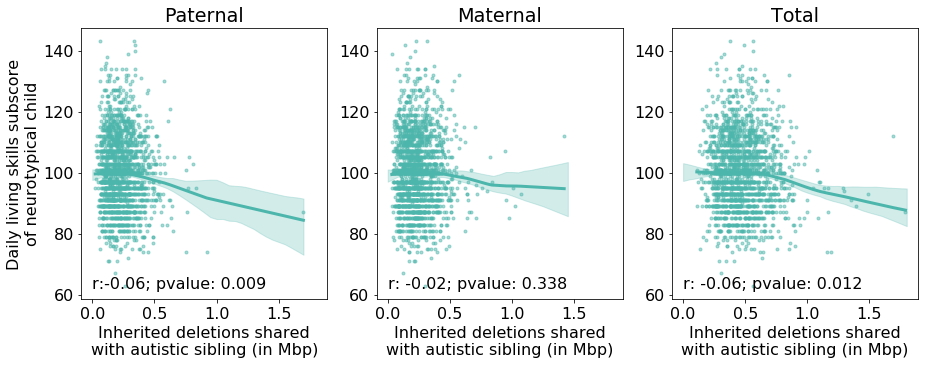

In [62]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

fig=plt.figure(figsize=(15, 5))

titles = ['Communication', 'Daily Living Skills', 'Social']
i = 1

ax = plt.subplot(1, 3, 1)

plt.subplot(1, 3, 1, sharex=ax, sharey=ax)
indices = (nt_phen[:, i]!=0) & ~is_outlier
plt.scatter(deletions_match[indices, 1]/1000000, nt_phen[indices, i], 
                marker='.', alpha=0.5, color=colors[1])
        
l = sm.nonparametric.lowess(nt_phen[indices, i], deletions_match[indices, 1]/1000000, return_sorted=True)
end_index = np.searchsorted(intervals, l[-1, 0])+1
plt.plot(l[:, 0], l[:, 1], linewidth=3,
                color=colors[1])
plt.fill_between(intervals[:end_index], np.quantile(bootstraps[:end_index, i, 1, :], 0.95, axis=1),
                    np.quantile(bootstraps[:end_index, i, 1, :], 0.05, axis=1), alpha=0.25, color=colors[1])
    
#plt.legend()
#plt.axhline(100, color='black', linestyle='--')
plt.text(0, 62, 'r:%0.2f; pvalue: %0.3f' % stats.pearsonr(deletions_match[indices, 1]/1000000, nt_phen[indices, i]))
plt.title('Paternal') 
plt.xlabel('Inherited deletions shared\nwith autistic sibling (in Mbp)')
plt.ylabel('Daily living skills subscore\nof neurotypical child')
    

plt.subplot(1, 3, 2, sharex=ax, sharey=ax)

plt.scatter(deletions_match[indices, 0]/1000000, nt_phen[indices, i], 
                marker='.', alpha=0.5, color=colors[1])
    
    
l = sm.nonparametric.lowess(nt_phen[indices, i], deletions_match[indices, 0]/1000000, return_sorted=True)
end_index = np.searchsorted(intervals, l[-1, 0])+1
plt.plot(l[:, 0], l[:, 1], linewidth=3, label='mat (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(deletions_match[indices, 0]/1000000, nt_phen[indices, i]),
            color=colors[1])
plt.fill_between(intervals[:end_index], np.quantile(bootstraps[:end_index, i, 0, :], 0.95, axis=1),
                    np.quantile(bootstraps[:end_index, i, 0, :], 0.05, axis=1), alpha=0.25, color=colors[1])
    
plt.text(0, 62, 'r: %0.2f; pvalue: %0.3f' % stats.pearsonr(deletions_match[indices, 0]/1000000, nt_phen[indices, i]))
plt.title('Maternal') 
#plt.legend()
#plt.axhline(100, color='black', linestyle='--')
plt.xlabel('Inherited deletions shared\nwith autistic sibling (in Mbp)')
#plt.ylabel('Vineland II subscore\nof neurotypical child')
    
plt.subplot(1, 3, 3, sharex=ax, sharey=ax)
plt.scatter(np.sum(deletions_match[indices, :], axis=1)/1000000, nt_phen[indices, i], 
                marker='.', alpha=0.5, color=colors[1])
l = sm.nonparametric.lowess(nt_phen[indices, i], np.sum(deletions_match[indices, :], axis=1)/1000000, return_sorted=True)
end_index = np.searchsorted(intervals, l[-1, 0])+1
plt.plot(l[:, 0], l[:, 1], linewidth=3, label='total (r=%0.2f\npvalue=%0.3f)' % stats.pearsonr(np.sum(deletions_match[indices, :], axis=1)/1000000, nt_phen[indices, i]),
            color=colors[1])
plt.fill_between(intervals[:end_index], np.quantile(bootstraps[:end_index, i, 2, :], 0.95, axis=1),
                    np.quantile(bootstraps[:end_index, i, 2, :], 0.05, axis=1), alpha=0.25, color=colors[1])
    
    
plt.text(0, 62, 'r: %0.2f; pvalue: %0.3f' % stats.pearsonr(np.sum(deletions_match[indices, :], axis=1)/1000000, nt_phen[indices, i]))
#plt.legend()
#plt.axhline(100, color='black', linestyle='--')
plt.title('Total')
plt.xlabel('Inherited deletions shared\nwith autistic sibling (in Mbp)')
#plt.ylabel('Vineland II subscore\nof neurotypical child')
        

#plt.tight_layout()
plt.savefig('../plots/subclinical.png', dpi=fig.dpi, bbox_inches='tight')

#plt.show()

In [63]:
X = np.hstack((deletions_match[indices, :]/1000000, np.ones((np.sum(indices), 1))))
y = nt_phen[indices, i]

model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.888
Date:                Thu, 02 Sep 2021   Prob (F-statistic):             0.0206
Time:                        15:14:14   Log-Likelihood:                -7450.2
No. Observations:                1916   AIC:                         1.491e+04
Df Residuals:                    1913   BIC:                         1.492e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -2.0998      2.112     -0.994      0.3